<h2><font color="#004D7F" size=5>Módulo 1: Modelos múltiples</font></h2>



<h1><font color="#004D7F" size=6> 4. Selección de clasificador dinámico </font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Aprendizaje Automático II</font><br>
<font color="#004D7F" size=3>Universidad Nacional de Educación a Distancia</font>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>


* [1. Selección del clasificador dinámico](#section1)
   * [1.1. Librería DESlib](#section11)
   * [1.2. Dataset](#section12)
* [2. Selección de Clasificadores dinámicos (DCS)](#section2)
    * [2.1. DCS-LA con accuracy local general (OLA)](#section21)
    * [2.2. DCS-LA con accuracy de clase local (LCA)](#section22)
* [3. Ajuste de hiperparámetros para DCS](#section3)
    * [3.1. Parámetro `k` en KNN](#section31)
    * [3.2. Explorar algoritmos para el grupo de clasificadores](#section32)
* [Ejercicios](#sectionEj)

---

<a id="section0"></a>
# <font color="#004D7F">0. Contexto</font>

La técnica implica ajustar múltiples modelos de aprendizaje automático en el conjunto de datos de entrenamiento y luego seleccionar el modelo que se espera que funcione mejor al hacer una predicción, en función de los detalles específicos del ejemplo que se va a predecir. Por tanto, en este tutorial trabajaremos:
- Los algoritmos de selección de clasificador dinámico eligen uno entre muchos modelos para hacer una predicción para cada nuevo ejemplo.
- Cómo desarrollar y evaluar modelos de selección de clasificadores dinámicos para tareas de clasificación utilizando Scikit-learn.
- Cómo explorar el efecto de los hiperparámetros del modelo de selección de clasificador dinámico clasificación.

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section1"></a>
# <font color="#004D7F"> 1. Selección del clasificador dinámico</font>

__Selección de clasificador dinámico (DCS)__: 
- Son algoritmos que eligen uno de entre muchos modelos entrenados para hacer una predicción basada en los detalles específicos de la entrada.
- Los algoritmos DCS generalmente implican dividir el espacio de características de entrada de alguna manera y asignar modelos específicos que sean responsables de hacer predicciones para cada partición.
- Los esfuerzos de investigación se centran principalmente en cómo evaluar y asignar clasificadores a regiones específicas del espacio de entrada.

```text
Después de capacitar a varios clasificadores individuales, DCS selecciona dinámicamente un clasificador para cada instancia de prueba. [...] DCS hace predicciones utilizando un clasificador individual.
        -- Página 93, Ensemble Methods: Foundations and Algorithms, 2012.
```
Enfoque __Dynamic Classifier Selection Local Accuracy (DCS-LA)__ (del artículo _Combination Of Multiple Classifiers Using Local Accuracy Estimates_, 1997):
- Primero adapta un conjunto pequeño y diverso de modelos de clasificación al conjunto de datos de entrenamiento.
- Cuando se requiere una predicción, primero se utiliza un algoritmo KNN para encontrar los _k_ ejemplos más similares del conjunto de datos de entrenamiento que coincidan con el ejemplo.
- Luego, cada clasificador previamente ajustado en el modelo se evalúa en el vecino de _k_ ejemplos de entrenamiento y se selecciona el clasificador que funciona mejor para hacer una predicción para el nuevo ejemplo.
- "La idea básica es estimar el accuracy de cada clasificador en la región local del espacio de características que rodea una muestra de test desconocida y luego utilizar la decisión del clasificador más preciso localmente." 

Dos enfoques para seleccionar un modelo:
- __Accuracy local (LA u OLA)__,:
    1. Evalua el accuracy de la clasificación de cada modelo en la vecindad de _k_ ejemplos de entrenamiento.
    2. Luego se selecciona el modelo que funciona mejor en este vecindario para hacer una predicción para el nuevo ejemplo.
- __Accuracy de clase (CA o LCA)__:
    1. Utiliza cada modelo para hacer una predicción para el nuevo ejemplo y anotar la clase que se predijo.
    2. Luego, se evalúa el accuracy de cada modelo en el vecino de _k_ ejemplos de entrenamiento y
    3. Se selecciona el modelo que tiene la mejor habilidad para la clase que predijo en el nuevo ejemplo y se devuelve su predicción.

<a id="section11"></a>
## <font color="#004D7F"> 1.1. Librería DESlib</font>

_Dynamic ensemble selection library in Python_ (DESlib) es una biblioteca de código abierto que proporciona una implementación de muchos algoritmos diferentes de selección de clasificadores dinámicos. 

Instalamos `deslib`.

In [3]:
#!pip install deslib

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la librería [DESlib](https://deslib.readthedocs.io/en/latest/).
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la librería [DESlib](https://deslib.readthedocs.io/en/latest/).
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre el Github [DESlib](https://github.com/scikit-learn-contrib/DESlib).
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información en PyPI sobre [DESlib](https://pypi.org/project/DESlib/0.1/).
</div>

In [4]:
# check deslib version
import deslib
print(deslib.__version__)

0.3.7


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Puede que tenga que reiniciar el kernel para que pueda ejecutarse correctamente la librería.
</div>

DESlib proporciona una implementación del algoritmo DCS-LA con cada técnica de selección de clasificador a través de las clases OLA y LCA. 
- Cada clase se puede utilizar directamente como modelo de Scikit-learn.
- Ambas clases utilizan un algoritmo KNN para seleccionar el vecino con un valor predeterminado de `k = 7`. 
- Se utiliza Bagging como conjunto de modelos considerados para cada clasificación que se realiza.

<a id="section12"></a>
## <font color="#004D7F"> 1.2. Dataset</font>

Usamos `make_classification()` para crear un problema de clasificación binaria sintética con 10,000 ejemplos y 20 características de entrada.

In [5]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
print(X.shape, y.shape)

(10000, 20) (10000,)


---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section2"></a> 
# <font color="#004D7F"> 2. Selección de Clasificadores dinámicos (DCS) </font>

Veamos cómo utilizar cada algoritmo DCS-LA y DCS-LCA.

<a id="section21"></a> 
## <font color="#004D7F"> 2.1. DCS-LA con accuracy local general (OLA)</font>

Podemos evaluar un modelo DCS-LA utilizando el accuracy local en el conjunto de datos sintéticos. 

<a id="section211"></a> 
### <font color="#004D7F"> 2.1.1. Evaluación</font>

Veamos la evaluación:
- Usaremos hiperparámetros por defecto: Bagging como conjunto de modelos clasificadores y `k = 7` para la vecindad local al hacer una predicción. 
- Utilizamos una validación cruzada estratificada repetida de _k_ veces con tres repeticiones y 10 pliegues. 

In [6]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from deslib.dcs.ola import OLA

# definir el modelo
model = OLA()
# Validación cruzada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluación
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# reportar el rendimiento
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.881 (0.012)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section212"></a> 
### <font color="#004D7F"> 2.1.2. Predicción</font>

También podemos utilizar el modelo DCS-LA con OLA como modelo final y hacer predicciones para la clasificación. Primero, el modelo se ajusta a todos los datos disponibles, luego se puede llamar a la función `predict()` para hacer predicciones sobre nuevos datos. 

In [7]:
from deslib.dcs.ola import OLA

# denifinir el modelo
model = OLA()
# entrenamiento
model.fit(X, y)
# Hacer una predicción
row = [-1.90710794,  1.52433471,  1.84973007,  2.35366976,  0.25355192,
        0.00748397, -0.89773414,  0.23576555, -2.67630958,  0.48313739,
       -0.01546079,  2.32326935,  1.94527582,  2.96824161, -2.23528952,
        0.66418332, -2.76591587,  1.48221875, -1.17071345,  6.41199015]
pred = model.predict([row])
# summarize the prediction
print('Predicción: %d' % pred[0])

Predicción: 1


<a id="section22"></a> 
## <font color="#004D7F"> 2.2. DCS-LA con accuracy de clase local (LCA)</font>

Podemos evaluar un modelo DCS-LA con LCA utilizando la precisión de clase local en el conjunto de datos sintéticos.

<a id="section221"></a> 
### <font color="#004D7F"> 2.2.1. Evaluación</font>

Veamos la evaluación:
- Usaremos hiperparámetros por defecto: Bagging como conjunto de modelos clasificadores y `k = 7` para la vecindad local al hacer una predicción. 
- Utilizamos una validación cruzada estratificada repetida de _k_ veces con tres repeticiones y 10 pliegues. 

In [8]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from deslib.dcs.lca import LCA

# definir el modelo
model = LCA()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.918 (0.008)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section212"></a> 
### <font color="#004D7F"> 2.1.2. Predicción</font>

También podemos utilizar el modelo DCS-LA con LCA como modelo final y hacer predicciones para la clasificación. Primero, el modelo se ajusta a todos los datos disponibles, luego se puede llamar a la función `predict()` para hacer predicciones sobre nuevos datos. 

El siguiente ejemplo demuestra esto en nuestro conjunto de datos de clasificación binaria.

In [9]:
# make a prediction with DCS-LA using local class accuracy
from sklearn.datasets import make_classification
from deslib.dcs.lca import LCA

# ddefinir el modelo
model = LCA()
model.fit(X, y)
row = [-1.90710794,  1.52433471,  1.84973007,  2.35366976,  0.25355192,
        0.00748397, -0.89773414,  0.23576555, -2.67630958,  0.48313739,
       -0.01546079,  2.32326935,  1.94527582,  2.96824161, -2.23528952,
        0.66418332, -2.76591587,  1.48221875, -1.17071345,  6.41199015]
pred = model.predict([row])
print('Predicción: %d' % pred[0])

Predicción: 1


---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section3"></a> 
# <font color="#004D7F"> 3. Ajuste de hiperparámetros para DCS</font>

En esta sección, analizaremos dos de los principales hiperparámetros:
- El valor de `k` en el modelo KNN utilizado en la evaluación local de los modelos, y
- Cómo usar un hiperparámetro personalizado para el conjunto de clasificadores.

Usaremos DCS-LA con OLA como base para estos experimentos.

<a id="section31"></a> 
## <font color="#004D7F"> 3.1. Parámetro `k` en KNN</font>

La configuración del algoritmo de KNN es fundamental para el modelo DCS-LA ya que define el alcance de la vecindad en la que se considera cada clasificador para la selección. El valor `k` controla el tamaño de la vecindad:
- Valores demasiado pequeños significará que los ejemplos relevantes en el conjunto de entrenamiento podrían excluirse de la vecindad.
- Valores demasiado grandes pueden significar que la señal está siendo eliminada por demasiados ejemplos. 

Veamos un ejemplo de DCS-LA con OLA para valores `k` de 2 a 21.

>2 0.870 (0.012)
>3 0.873 (0.009)
>4 0.875 (0.009)
>5 0.880 (0.009)
>6 0.880 (0.011)
>7 0.882 (0.010)
>8 0.883 (0.010)
>9 0.885 (0.012)
>10 0.885 (0.011)
>11 0.885 (0.010)
>12 0.885 (0.011)
>13 0.886 (0.009)
>14 0.888 (0.010)
>15 0.889 (0.009)
>16 0.888 (0.011)
>17 0.887 (0.012)
>18 0.888 (0.010)
>19 0.886 (0.010)
>20 0.890 (0.009)
>21 0.891 (0.010)


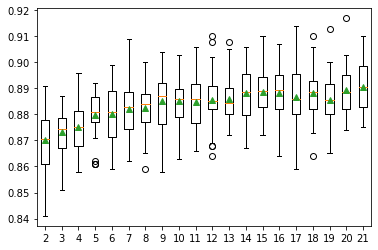

In [10]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from deslib.dcs.ola import OLA
from matplotlib import pyplot

def get_dataset():
    X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
    return X, y

# lista de modelos a evaluar (valor e k de 2 a 21)
def get_models():
    models = dict()
    for i in range(2, 22):
        models[str(i)] = OLA(k=i)
    return models

# evaluar el modelo
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# dataset
X, y = get_dataset()
# obtener modelos a evaluar
models = get_models()
# evaluar y almacenar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section32"></a> 
## <font color="#004D7F"> 3.2. Explorar algoritmos para el grupo de clasificadores</font>

De forma predeterminada se utilizan árboles de decisión Bagging.

<a id="section321"></a> 
### <font color="#004D7F"> 3.2.1. Grupo de clasificadores</font>

Se puede considerar un grupo personalizado de clasificadores. 
- Como no podemos utilizar una validación cruzada vamos a utilizar un partición por porcentaje.
- La lista de clasificadores aptos se puede especificar para la clase OLA (o LCA) a través del argumento `pool_classifiers`.
- En este caso, utilizaremos un grupo que incluye regresión logística, un árbol de decisión y Naive Bayes. 

In [11]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from deslib.dcs.ola import OLA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

X, y = get_dataset()
# Particiòn en un 50%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# definimos los clasificadores
classifiers = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB()]
# Entrenamos cada clasificador en train
for c in classifiers:
    c.fit(X_train, y_train)
# definimos el modelo DCS-LA
model = OLA(pool_classifiers=classifiers)
# entrenamos el metamodelo
model.fit(X_train, y_train)
# hacer las predicciónes en test y sacar el accuracy
pred = model.predict(X_test)
# evaluate predictions
score = accuracy_score(y_test, pred)
print('Accuracy: %.3f' % (score))

Accuracy: 0.912


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section322"></a> 
### <font color="#004D7F"> 3.2.2. Modelo contribuyente</font>

- Para adoptar el modelo DCS, debe funcionar mejor que cualquier modelo contribuyente.
- De lo contrario, simplemente utilizaríamos el modelo contribuyente que funcione mejor.
- Podemos verificar esto evaluando el desempeño de cada clasificador contribuyente en test.

In [12]:
# evaluate contributing models
print('Accuracy total: %.3f' % (score))
for c in classifiers:
    pred = c.predict(X_test)
    score = accuracy_score(y_test, pred)
    print('>%s: %.3f' % (c.__class__.__name__, score))

Accuracy total: 0.912
>LogisticRegression: 0.878
>DecisionTreeClassifier: 0.884
>GaussianNB: 0.873


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="sectionEj"></a>
<h3><font color="#004D7F" size=6> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> Ejercicios</font></h3>

Se proponen las siguientes actividades para consolidar el aprendizaje.

# <font color="#004D7F" size=5>Ejercicio 1</font>
__DCS-LA con LCA__. En los ejemplos finales hemos visto para OLA, utilice el ejemplo con LCA.

>2 0.969 (0.006)
>3 0.962 (0.007)
>4 0.954 (0.006)
>5 0.942 (0.007)
>6 0.931 (0.009)
>7 0.918 (0.010)
>8 0.909 (0.009)
>9 0.897 (0.010)
>10 0.886 (0.010)
>11 0.875 (0.012)
>12 0.869 (0.010)
>13 0.860 (0.010)
>14 0.854 (0.010)
>15 0.844 (0.017)
>16 0.835 (0.012)
>17 0.832 (0.013)
>18 0.824 (0.013)
>19 0.820 (0.016)
>20 0.817 (0.014)
>21 0.812 (0.013)


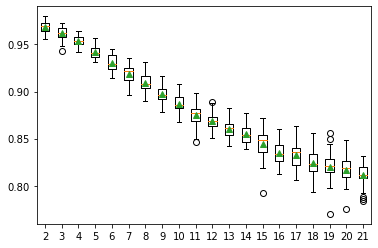

In [13]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from deslib.dcs.ola import OLA
from matplotlib import pyplot

def get_dataset():
    X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
    return X, y

# lista de modelos a evaluar (valor e k de 2 a 21)
def get_models():
    models = dict()
    for i in range(2, 22):
        models[str(i)] = LCA(k=i)
    return models

# evaluar el modelo
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# dataset
X, y = get_dataset()
# obtener modelos a evaluar
models = get_models()
# evaluar y almacenar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# <font color="#004D7F" size=5>Ejercicio 2</font>
__Hiperparámetros__. ¿Qué otros hiperparámetros se pueden utilizar? Indaga y descubra más hiperparámetros y evalúe su uso.

# Hiperparámetros de OLA y LCA

## OLA (Omni-Modal Language Model)

El modelo OLA es un modelo de lenguaje omni-modal que soporta entradas de texto, imagen, video y audio. Aquí tienes algunos de los hiperparámetros clave que puedes ajustar:

1. **Número de capas (`num_layers`)**: Determina la profundidad del modelo.
2. **Tamaño del hidden layer (`hidden_size`)**: Controla el tamaño de las capas ocultas.
3. **Número de cabezas de atención (`num_attention_heads`)**: Afecta la capacidad del modelo para enfocarse en diferentes partes de la entrada.
4. **Tamaño del vocabulario (`vocab_size`)**: Define el número de tokens que el modelo puede manejar.
5. **Ventana de contexto (`context_window`)**: Controla la cantidad de contexto que el modelo puede considerar al hacer predicciones.

## LCA (Life Cycle Assessment)

El Análisis de Ciclo de Vida (LCA) no es un modelo de aprendizaje automático, sino una metodología para evaluar los impactos ambientales de un producto o servicio a lo largo de su ciclo de vida. Sin embargo, en el contexto de modelos de aprendizaje automático que pueden utilizarse para LCA, aquí tienes algunos hiperparámetros comunes:

1. **Definición del objetivo y alcance (`goal_scope_definition`)**: Especifica el propósito del estudio y los límites del sistema.
2. **Inventario del ciclo de vida (`life_cycle_inventory`)**: Recopila datos sobre las entradas y salidas del sistema.
3. **Evaluación del impacto del ciclo de vida (`impact_assessment`)**: Analiza los impactos ambientales asociados con las entradas y salidas.
4. **Interpretación de resultados (`results_interpretation`)**: Proporciona conclusiones y recomendaciones basadas en los resultados del análisis.

Estos hiperparámetros te permiten ajustar y optimizar tanto los modelos de lenguaje como las evaluaciones de ciclo de vida para obtener los mejores resultados posibles.

# <font color="#004D7F" size=5>Ejercicio 3</font>
__Más conjuntos de datos__. Busque un dataset original y verdadero (que no sea sintético) y evalúe el uso de los conceptos vistos en esta unidad. Los conjuntos de datos en pueden ser obtenidos del [repositorio de aprendizaje automático de UCI](https://archive.ics.uci.edu/).

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine

# Cargar el dataset
data = load_wine()
X = data.data
y = data.target

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# definimos los clasificadores
classifiers = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB()]
# Entrenamos cada clasificador en train
for c in classifiers:
    c.fit(X_train, y_train)
# definimos el modelo DCS-LA
model = OLA(pool_classifiers=classifiers)
# entrenamos el metamodelo
model.fit(X_train, y_train)
# hacer las predicciónes en test y sacar el accuracy
pred = model.predict(X_test)
# evaluate predictions
score = accuracy_score(y_test, pred)
print('Accuracy: %.3f' % (score))

# evaluate contributing models
print('Accuracy total: %.3f' % (score))
for c in classifiers:
    pred = c.predict(X_test)
    score = accuracy_score(y_test, pred)
    print('>%s: %.3f' % (c.__class__.__name__, score))

Accuracy: 0.983
Accuracy total: 0.983
>LogisticRegression: 0.983
>DecisionTreeClassifier: 0.949
>GaussianNB: 1.000


# <font color="#004D7F" size=5>Ejercicio 4</font>
__Clasificadores__. Evalué todo los ejercicios anteriores con el uso de clasificadores distintos a los vistos en la unidad, i.e., diferentes a LoR, CART y NB.

In [17]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from deslib.dcs.ola import OLA
from sklearn.metrics import accuracy_score

# Cargar el dataset
data = load_wine()
X = data.data
y = data.target

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir nuevos clasificadores
classifiers = [SVC(), RandomForestClassifier(), KNeighborsClassifier()]

# Entrenar cada clasificador en train
for c in classifiers:
    c.fit(X_train, y_train)

# Definir el modelo DCS-LA
model = OLA(pool_classifiers=classifiers)

# Entrenar el metamodelo
model.fit(X_train, y_train)

# Hacer las predicciones en test y calcular el accuracy
pred = model.predict(X_test)
score = accuracy_score(y_test, pred)
print('Accuracy: %.3f' % (score))

# Evaluar los modelos contribuyentes
print('Accuracy total: %.3f' % (score))
for c in classifiers:
    pred = c.predict(X_test)
    score = accuracy_score(y_test, pred)
    print('>%s: %.3f' % (c.__class__.__name__, score))

Accuracy: 0.983
Accuracy total: 0.983
>SVC: 0.983
>RandomForestClassifier: 1.000
>KNeighborsClassifier: 0.966


# <font color="#004D7F" size=5>Ejercicio 5</font>
__Más sobre DESlib__. DESlib es una librería muy interesante que incluye una gran cantidad de modelos y técnicas. Selecciona 4 técnicas adicionales y desarróllelas (tanto teóricamente de la técnica como la práctica).

# Técnicas de DESlib

La biblioteca **DESlib** (Dynamic Ensemble Selection Library) ofrece una variedad de técnicas avanzadas para la selección dinámica de clasificadores y conjuntos. Aquí tienes un resumen de las principales técnicas que permite:

## Técnicas de Selección Dinámica de Clasificadores (DCS)

1. **OLA (Overall Local Accuracy)**: Selecciona el clasificador con la mayor precisión local en la región de competencia.
2. **A Priori**: Selecciona el clasificador basado en la precisión a priori en la región de competencia.
3. **MCB (Multiple Classifier Behavior)**: Selecciona el clasificador basado en el comportamiento múltiple de los clasificadores en la región de competencia.

## Técnicas de Selección Dinámica de Conjuntos (DES)

1. **KNORA-Union (K-Nearest Oracles Union)**: Selecciona un conjunto de clasificadores que han clasificado correctamente al menos una muestra en la región de competencia.
2. **KNORA-Eliminate (K-Nearest Oracles Eliminate)**: Selecciona un conjunto de clasificadores que han clasificado correctamente todas las muestras en la región de competencia.
3. **DES-P (Dynamic Ensemble Selection Performance)**: Selecciona un conjunto de clasificadores basado en su rendimiento en la región de competencia.
4. **META-DES**: Utiliza un meta-clasificador para seleccionar el mejor conjunto de clasificadores basado en características dinámicas.

## Ejemplo de Uso

Aquí tienes un ejemplo de cómo utilizar la técnica KNORA-Eliminate con un conjunto de clasificadores de RandomForest:

```python
from sklearn.ensemble import RandomForestClassifier
from deslib.des.knora_e import KNORAE
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar el dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entrenar un conjunto de clasificadores
pool_classifiers = RandomForestClassifier(n_estimators=10)
pool_classifiers.fit(X_train, y_train)

# Inicializar el modelo DES
knorae = KNORAE(pool_classifiers)

# Preprocesar el conjunto de datos de selección dinámica (DSEL)
X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
knorae.fit(X_dsel, y_dsel)

# Predecir nuevas muestras
y_pred = knorae.predict(X_test)

---

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>